# IS620 Final Project

Data:  ~4200 pub med journals, including author affilations.  The affiliations are not provided in an specified manner, and are instead long 'strings'.  

Goal:  It is not clear, looking at the strings, how to distinuish instituion names from department names and so on.  The goal here is to develop a maching learning algo which can pull instinution names from the affilations, such that a graph of schools which publish with eachother might be generated.

Results:  A decision tree was found to be most appliciable.  The accuracy was ~92% with the test set.  However, this only tells part of the story; I labeled a training set of ~4000 samples, and some of these I mislabeled.  Thus the machine learning had to properly assign labels that I had put in incorrectly!




In [82]:
%matplotlib inline
import random
import nltk
import string
import networkx as nx
import io
import matplotlib.pyplot as plt
import pandas as pd

In [83]:
## Here we open a file of downloaded journal articles including author names and affiliations.
pubs = []
with open('project2pubs.txt','r') as f:
    for line in f:
        pubs.append(line.split(']]'))
        

In [84]:
## As you can see, the data is a mess
pubs[0]

["[['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'], ['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X'",
 ',Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy of Sciences, Shanghai, China. Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy of Sciences, Shanghai, China. Key Laboratory of Stem Cell Biology, Institute of Health Sciences, Shanghai Institutes for Biological Sciences &Shanghai Jiao Tong University School of Medicine (SJTUSM), Chinese Academy o

In [85]:
## The form of the strings in the files, are a mess, a much effort needed to clean it all up
stringIn = "string.with.punctuation!"

author = []
for x in pubs:
    if isinstance(x, list):
        t = (x[0].translate(None, '!@#$][,').split("'"))
        temp = []
        for x in t: 
            if x:
                if x != " ":
                    if x not in temp:
                       temp.append(x)
        author.append(temp)
            
        
    
author[0]

['Ma Y', 'Zhang J', 'Yin W', 'Zhang Z', 'Song Y', 'Chang X']

In [86]:
len(author)

4215

In [87]:
len(pubs)

4215

In [88]:
## The affiliation data is a mess.  Sometimes its deliminated with . or ;, etcetera.  
## below we split up each affiliation using a number of delimiters

splitcomma = []
splitperiod = []
splitsemicolon = []
splitspace = []
for x in pubs:
    if len(x) > 1:
        s = x[1]
        s = s[:-1]
        t = s.split(",")
        if len(t)>2:
            t = t[:-2]  # remove journal names
        else:
            t = " "
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitcomma.append(t)
        t = s.split(".")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitperiod.append(t)
        t = s.split(";")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitsemicolon.append(t)
        t = s.split(" ")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitspace.append(t)
    else:
        splitcomma.append("")
        splitperiod.append("")
        splitsemicolon.append("")
        splitspace.append("")
        

    
        


In [89]:
def stringHasPunct(s):
    if not s:
        return True
    for x in string.punctuation:
        if x in s:
            return True
    return False

In [90]:
## below we generate a list of all possible 'phrases' in the affiliation

listterms = []
for x in range(0, len(splitcomma)):
    temp = []
    t = []
    for y in splitcomma[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    t = []
    for y in splitsemicolon[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    t = []
    for y in splitperiod[x]:
        if not stringHasPunct(y):
            t.append(y)
    temp.append(t)
    listterms.append(temp)

In [91]:
## example affiliations are shown below.  The question is, can
## a machine learning classification determine which are institution names??
listterms[2]

[['Qinghai Provincial Key Laboratory for Plague Control and Research',
  'Qinghai Institute for Endemic Disease Prevention and Control',
  'Xining',
  'Qinghai Province',
  '811602',
  'Fengtai',
  'Beijing',
  '100071',
  'Qinghai Institute for Endemic Disease Prevention and Control',
  'Xining',
  'Qinghai Province',
  '811602',
  'Fengtai',
  'Beijing',
  '100071'],
 [],
 ['com']]

In [92]:
## I save all the phrases to a csv.  I will label some of the 
## phrases in the csv file to then train the system.
f = open('labelAffiliations.txt','w')
for x in listterms:
    for y in x:
        for z in y:
            f.write(str(z) + '\n') 
f.close() 


In [93]:
## in excel, I marked >4000 'phrases' as belonging to an 
## instituion or not.  Most of these were just zip codes and such,
## so easy to mark.

phrase = []
label = []
with open('labelAffiliations.csv') as f:
    for line in f:
        line = line.rstrip()
        line = line.split(",")
        if len(line) >1 and line[1]:
            phrase.append(line[0])
            label.append(line[1])
            
            

In [94]:
len(label)

4866

In [95]:
## get all words used in any labeled affiliation
words = []
for x in phrase:
    x = x.split(" ")
    for y in x:
        words.append(y)
        

In [96]:
len(words)

15304

In [97]:
#look at the top 200 words
all_words = nltk.FreqDist(words)
top100 = all_words.most_common(50)

In [98]:
word_feature = []
for x in top100:
    word_feature.append(x[0])

In [99]:
word_feature

['of',
 'and',
 'Department',
 'for',
 'Center',
 'Biology',
 'University',
 'Institute',
 'Research',
 'Sciences',
 'Medicine',
 'Division',
 'Science',
 'Molecular',
 'Cell',
 'Medical',
 'Centre',
 'College',
 'Cancer',
 'Street',
 'de',
 'Genetics',
 'Laboratory',
 'Road',
 'Engineering',
 'Avenue',
 'National',
 'in',
 'Beijing',
 'Microbiology',
 'Technology',
 'New',
 'Health',
 'Biological',
 'Biotechnology',
 'Drive',
 'School',
 'China',
 'CA',
 'Cambridge',
 'Biochemistry',
 'Biol',
 'a',
 'the',
 'York',
 'Life',
 'Diseases',
 'California',
 '1',
 'Biomedical']

In [100]:
listterms[0]

[['Key Laboratory of Stem Cell Biology',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'University of California at San Diego',
  'La Jolla',
  'La Jolla',
  'California',
  'Institute of Health Sciences',
  'Chinese Academy of Sciences',
  'Shanghai',
  'Shanghai Jiao Tong University School of Medicine',
  'Shanghai'],
 [],
 []]

In [101]:
## the feature I want to look at.  

def getContentIndex(listterms_x, phrase):
    '''what affiliation does a phrase occur in.
    Bear in mind that I labeled phrases free of any context
    and now need to figure out which affilation each phrase come from'''
    for x in listterms_x: ## x is a list ['ewfew', 'wefew' ]
        if phrase in x:
            return x.index(phrase), x
    else:
        return False, False

def hasNumber(word):
    for x in word:
        if is_number(x):
            return True
    return False

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def firstWordisCapital(x):
    fl = x[0]
    if is_number(fl):
        return False
    if fl == fl.upper():
        return True
    return False

def ratioOfCaptialLetters(phrase):
    p = phrase.split()
    c = 0
    for x in p:
        for y in x:
            if not is_number(y):
                if y == y.upper():
                    c += 1
    if len(p) != 0:
        r = c/float(len(p))
    else:
        r = 0
    return int(r*10)

def numberOfWords(phrase):
    p = phrase.split()
    return int(len(p)/2)

def oneWord(phrase):
    p = phrase.split()
    if len(p) == 1:
        return True
    else:
        return False
    

def totalLen(phrase):
    return int(len(phrase)/10)
    
                
    

In [102]:
for word in word_feature:
        (word in set())

In [103]:
def document_features_old(context, phrase, word_feature):
    doci, i = getContentIndex(context, phrase)
    
    context = context[i]
    document_words = set(phrase.split())
    features = {}
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    
    if doci != 0:
        phrasebefore = context[doci-1]
        document_words = set(phrasebefore)
        #for word in word_feature:
            #features['phraseBeforeContains(%s)' % word] = (word in set(document_words))
        features['isnumericBefore'] = is_number(phrasebefore)
        features['hasANumberInItBefore'] = hasNumber(phrasebefore)
        features['firstLetterCapitalBefore'] = firstWordisCapital(phrasebefore)
        features['ratioOfCaptialLettersBefore'] = ratioOfCaptialLetters(phrasebefore)
        features['numberOfWordsBefore'] = numberOfWords(phrasebefore)
        features['startsWithNumberBefore'] = is_number(phrasebefore[0])
        features['totalLengthBefore'] = totalLen(phrasebefore)
        features['oneWordBefore'] = oneWord(phrasebefore)
        
    
    if doci + 1 < len(context):
        phraseafter = context[doci+1]
        document_words = set(phraseafter)
        #for word in word_feature:
            #features['phraseAfterContains(%s)' % word] = (word in set(document_words))
        features['isnumericAfter'] = is_number(phraseafter)
        features['hasANumberInItAfter'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter'] = numberOfWords(phraseafter)
        features['startsWithNumberAfter'] = is_number(phraseafter[0])
        features['totalLengthAfter'] = totalLen(phraseafter)
        features['oneWordAfter'] = oneWord(phraseafter)
    if doci + 2 < len(context):
        phraseafter = context[doci+2]
        document_words = set(phraseafter)
        #for word in word_feature:
            #features['phraseAfter2Contains(%s)' % word] = (word in set(document_words))
        features['isnumericAfter2'] = is_number(phraseafter)
        features['hasANumberInItAfter2'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter2'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter2'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter2'] = numberOfWords(phrase)
        features['totalLengthAfter2'] = totalLen(phraseafter)
        features['oneWordAfter2'] = oneWord(phraseafter)
    if doci + 3 < len(context):
        phraseafter = context[doci+3]
        document_words = set(phraseafter)
        #for word in word_feature:
            #features['phraseAfter3Contains(%s)' % word] = (word in set(document_words))
        features['isnumericAfter3'] = is_number(phraseafter)
        features['hasANumberInItAfter3'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter3'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter3'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter3'] = numberOfWords(phraseafter)
        features['totalLengthAfter3'] = totalLen(phraseafter)
        
        
    return features

In [104]:
def document_features(context, phrase, word_feature):
    ## context is the 'listterms' which is a list of 3 lists

    doci, context = getContentIndex(context, phrase)
    document_words = set(phrase.split())
    features = {}
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    
    if doci != 0:
        phrasebefore = context[doci-1]
        document_words = set(phrasebefore.split())
        #for word in word_feature:
            #features['phraseBeforeContains(%s)' % word] = (word in set(document_words))
        features['isnumericBefore'] = is_number(phrasebefore)
        features['hasANumberInItBefore'] = hasNumber(phrasebefore)
        features['firstLetterCapitalBefore'] = firstWordisCapital(phrasebefore)
        features['ratioOfCaptialLettersBefore'] = ratioOfCaptialLetters(phrasebefore)
        features['numberOfWordsBefore'] = numberOfWords(phrasebefore)
        features['startsWithNumberBefore'] = is_number(phrasebefore[0])
        features['totalLengthBefore'] = totalLen(phrasebefore)
        features['oneWordBefore'] = oneWord(phrasebefore)
    if doci + 1 < len(context):
        phraseafter = context[doci+1]
        document_words = set(phraseafter.split())
        #for word in word_feature:
            #features['phraseAfterContains(%s)' % word] = (word in set(document_words))
        features['isnumericAfter'] = is_number(phraseafter)
        features['hasANumberInItAfter'] = hasNumber(phraseafter)
        features['firstLetterCapitalAfter'] = firstWordisCapital(phraseafter)
        features['ratioOfCaptialLettersAfter'] = ratioOfCaptialLetters(phraseafter)
        features['numberOfWordsAfter'] = numberOfWords(phraseafter)
        features['startsWithNumberAfter'] = is_number(phraseafter[0])
        features['totalLengthAfter'] = totalLen(phraseafter)
        features['oneWordAfter'] = oneWord(phraseafter)
    return features

In [105]:
def document_features(context, phrase, word_feature):
    ## context is the 'listterms' which is a list of 3 lists

    document_words = set(phrase.split())
    features = {}
    for word in word_feature:
        features['contains(%s)' % word] = (word in document_words)
    features['isnumeric'] = is_number(phrase)
    features['hasANumberInIt'] = hasNumber(phrase)
    features['firstLetterCapital'] = firstWordisCapital(phrase)
    features['ratioOfCaptialLetters'] = ratioOfCaptialLetters(phrase)
    features['numberOfWords'] = numberOfWords(phrase)
    features['startsWithNumber'] = is_number(phrase[0])
    features['totalLength'] = totalLen(phrase)
    features['oneWord'] = oneWord(phrase)
    return features

In [106]:
d_phrases = {}
for x in range(0, len(phrase)):
    d_phrases[phrase[x]] = label[x]

In [107]:
random.shuffle(listterms)
len(d_phrases)

4177

In [108]:
listterms[0] ## each list has 3 lists (split by comma, semicolon, etc...)

[['Basic Science and Experimental Medicine Institute',
  'University Institute of the Italian Hospital',
  'C1181ACH Buenos Aires',
  'University Institute of the Italian Hospital',
  'C1181ACH Buenos Aires',
  'University Institute of the Italian Hospital',
  'C1181ACH Buenos Aires'],
 [],
 []]

In [109]:
featuresets = []
phrasesLookedUp = []
for x in listterms:
    for y in x:
        for z in y:
            if z in d_phrases:
                featuresets.append([document_features(x, z, word_feature), d_phrases[z]]) 
                phrasesLookedUp.append(z)


In [110]:
train_set, test_set = featuresets[2500:], featuresets[:2500]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [111]:
## achieve 90% accuracy
print nltk.classify.accuracy(classifier, test_set)

0.9476


In [112]:
## 92% of the test set are not instituions.  At first this seems like bad news.
## But look at errors below
c = 0
for x in test_set:
    if x[1] == 's':
        c += 1
1-float(c)/len(test_set)

0.9236

In [113]:
classifier.show_most_informative_features(30)

Most Informative Features
   ratioOfCaptialLetters = 6                   g : s      =     77.7 : 1.0
       contains(Biology) = True                g : s      =     63.3 : 1.0
      contains(Sciences) = True                g : s      =     57.0 : 1.0
    contains(Technology) = True                s : g      =     38.3 : 1.0
    contains(University) = True                s : g      =     24.1 : 1.0
           numberOfWords = 4                   g : s      =     22.2 : 1.0
             totalLength = 6                   g : s      =     18.2 : 1.0
        contains(School) = True                s : g      =     13.4 : 1.0
        contains(Health) = True                s : g      =     13.1 : 1.0
           contains(for) = True                g : s      =     13.0 : 1.0
          contains(Life) = True                g : s      =     11.1 : 1.0
      contains(Research) = True                g : s      =     10.5 : 1.0
           numberOfWords = 5                   g : s      =      9.9 : 1.0

In [114]:
errors = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase1 = phrasesLookedUp[i]
    if guess != tag:
        errors.append( (tag, guess, phrase1) )
    i += 1

In [115]:
## My main erors appear to be mis labeled as instituions --by me!-- and vice versa
## and the classifier has correctly labeled them..
## However, the classifier also likes to label cities as schools, despite they being a 
## single word...
list(set(errors))

[('g', 's', 'Beijing University of Technology'),
 ('g', 's', 'Niels Bohr Institute'),
 ('g', 's', 'Central South University'),
 ('g', 's', 'Broad Institute of MIT and Harvard'),
 ('g', 's', 'College of Public Health'),
 ('g', 's', 'College of Basic Medicine'),
 ('g', 's', 'Anhui Agricultural University'),
 ('g', 's', 'Charite University Medicine'),
 ('g', 's', 'Broad Institute of Harvard and MIT'),
 ('g', 's', 'China School of Basic Medical Sciences'),
 ('g', 's', 'National Institute of Environmental Health Sciences'),
 ('s', 'g', 'Berkeley'),
 ('s', 'g', 'New York Law School'),
 ('g', 's', 'National Institute of Chemistry'),
 ('g', 's', 'National Institute of Neurological Disorders and Stroke'),
 ('g',
  's',
  'David Geffen School of Medicine at University of California Los Angeles'),
 ('g', 's', 'College of Veterinary Medicine'),
 ('g', 's', 'Disease Control Laboratory Regina'),
 ('g', 's', 'Dalhousie University'),
 ('g', 's', 'Bloomberg School of Public Health'),
 ('g', 's', 'Baylo

In [116]:
## below is used to see what is marked as an institution
sguess = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase2 = phrasesLookedUp[i]
    if tag == 's':
        sguess.append( (tag, guess, phrase2) )
    i += 1

In [117]:
## lets see how a decision tree does
classifier_dt = nltk.classify.DecisionTreeClassifier.train(train_set)

In [118]:
## this error rate looks a bit better than for the bayes.
print nltk.classify.accuracy(classifier_dt, test_set)

0.964


In [119]:
## I see a lot of reasonable corrections to my assignments, so the 
## classifier is doing a better job than I.  Plus I don't see
## cities being named as institutions.  

errors = []
i = 0
for (name, tag) in test_set:
    guess = classifier.classify(name)
    phrase3 = phrasesLookedUp[i]
    if guess != tag:
        errors.append( (tag, guess, phrase3) )
    i += 1

list(set(errors))

[('g', 's', 'Beijing University of Technology'),
 ('g', 's', 'Niels Bohr Institute'),
 ('g', 's', 'Central South University'),
 ('g', 's', 'Broad Institute of MIT and Harvard'),
 ('g', 's', 'College of Public Health'),
 ('g', 's', 'College of Basic Medicine'),
 ('g', 's', 'Anhui Agricultural University'),
 ('g', 's', 'Charite University Medicine'),
 ('g', 's', 'Broad Institute of Harvard and MIT'),
 ('g', 's', 'China School of Basic Medical Sciences'),
 ('g', 's', 'National Institute of Environmental Health Sciences'),
 ('s', 'g', 'Berkeley'),
 ('s', 'g', 'New York Law School'),
 ('g', 's', 'National Institute of Chemistry'),
 ('g', 's', 'National Institute of Neurological Disorders and Stroke'),
 ('g',
  's',
  'David Geffen School of Medicine at University of California Los Angeles'),
 ('g', 's', 'College of Veterinary Medicine'),
 ('g', 's', 'Disease Control Laboratory Regina'),
 ('g', 's', 'Dalhousie University'),
 ('g', 's', 'Bloomberg School of Public Health'),
 ('g', 's', 'Baylo

In [120]:
## At this point, I think the decision tree is better

In [121]:
def splitIntoPhrases(affiliation):
    '''this long function is need to take each affilation string, and break it down into all its 
    possible deliminated pieces, and then take those and convert it to a list of 'phrases', one or more 
    of these phrases being a poissible institution name'''
    
    splitcomma = []
    splitperiod = []
    splitsemicolon = []
    splitspace = []
    if len(affiliation) > 1:
        #print (x)
        s = affiliation[1]
        s = s[:-1]
        
        t = s.split(",")
        if len(t)>2:
            t = t[:-2]  # remove journal names
        else:
            t = " "
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitcomma.append(t)
        t = s.split(".")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitperiod.append(t)
        t = s.split(";")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitsemicolon.append(t)
        t = s.split(" ")
        for x in range(0, len(t)):
            if isinstance(t[x], str):
                t[x] = str(t[x]).lstrip()
                t[x] = str(t[x]).rstrip()
        splitspace.append(t)
    else:
        splitcomma.append("")
        splitperiod.append("")
        splitsemicolon.append("")
        splitspace.append("")  ## not used
    listterms = []
    
    for x in range(0, len(splitcomma)):
        temp = []
        t = []
        for y in splitcomma[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        t = []
        for y in splitsemicolon[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        t = []
        for y in splitperiod[x]:
            if not stringHasPunct(y):
                t.append(y)
        temp.append(t)
        listterms.append(temp)
    return listterms

In [122]:
# I might as well train now on the full set of labeled data.
classifier = nltk.NaiveBayesClassifier.train(featuresets)
classifier_dt = nltk.classify.DecisionTreeClassifier.train(featuresets)

In [123]:
c = 0
predictions = []
for x in pubs:
    listphrases = splitIntoPhrases(x)
    t = []
    for i in listphrases:
        for j in i:
            for k in j:
                p = classifier_dt.classify(document_features(x, k, word_feature))
                if p == 's':  
                    t.append(k)
                else:
                    t.append('NA')
    predictions.append(t)
    c += 1

In [124]:
affiliations = []
for x in predictions:
    affiliations.append(list(set(x)))

In [125]:
for x in affiliations:
    if 'NA' in x:
        x.remove('NA')

In [126]:
affiliations[:10]

[['Shanghai Jiao Tong University School of Medicine',
  'University of California at San Diego'],
 [],
 [],
 ['University of Pennsylvania Perelman School of Medicine',
  'Michigan State University',
  'Kawasaki Medical School',
  'Graduate School of Medicine',
  'Kyoto University'],
 [],
 ['Creighton University'],
 ['Wageningen University', 'Faculty of Medicine University of Helsinki'],
 [],
 ['Tamagawa University', 'The University of Tokyo'],
 ['University of Turku and Abo Academy']]

In [127]:
g1 = []
for x in affiliations:
    if len(x)>1:
        for i in range(0, len(x)):
            for j in range(i+1, len(x)):
                g1.append([x[i], x[j]])

In [128]:
## Now save the undirected graph nodes
f = open('IS620Project3.csv','w')
for x in g1:
    f.write(str(x[0]) + "," +  str(x[1]) + '\n') 
f.close() 


In [129]:
# We will now analyse the resulting graph.
# Create the full graph by reading the 'IS620Project3.csv' file into a nx graph.
G = nx.read_edgelist('IS620Project3.csv', delimiter=',', nodetype=str)
# print out the edges
for e in G.edges():
    print e

('India School of Life Sciences', 'Jawaharlal Nehru University')
('Michigan Technological University', 'Shenzhen University')
('Michigan Technological University', 'Gautam Buddha University')
('Michigan Technological University', 'Henan Agricultural University')
('ShanghaiTech University', 'Third Military Medical University')
('ShanghaiTech University', 'Seoul National University')
('ShanghaiTech University', 'Yulin University')
('ShanghaiTech University', 'Nanjing Medical University')
('ShanghaiTech University', 'National Institutes of Health')
('ShanghaiTech University', 'University of Chinese Academy of Sciences')
('ShanghaiTech University', 'Model Animal Research Center of Nanjing University')
('ShanghaiTech University', 'Shanghai University of Traditional Chinese Medicine')
('ShanghaiTech University', 'Nanjing University')
('Tokushima University Graduate School', 'Osaka University')
('Tokushima University Graduate School', 'Graduate School of Frontier Biosciences')
('Tokushima Uni

In [130]:
# Display the number of nodes.
len(G.nodes())

570

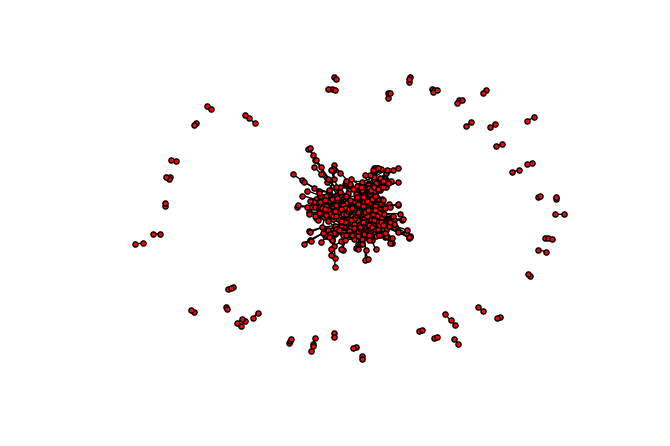

In [131]:
# Draw the raw graph. Notice the heavily connected subgraph in the middle. The rest of the sub-graphs are scattered
# around that sub-graph. Most of these smaller sub-graphs have less than 3 nodes each. 
# We will be interested in subgraphs that have a good connectivity (>25 nodes). 
# It seems like there is one very well connected sub-graph in  the center, the rest of the sub-graphs have very
# few nodes. We will investigate this further.
nx.draw_spring(G, with_labels=False, node_size=14)

In [132]:
# Display the number of sub-graphs. There are 44 sub-graphs in  this graph.
nx.number_connected_components(G)

44

In [133]:
# Get the sub graphs
graphs = list(nx.connected_component_subgraphs(G))

# Display the number of edges in each sub-graph. Notice that the 2nd sub-graph (index 1) has many more edges. This is
# the one that is of most interest. We will analyze this subgraph.
for graph in graphs:
    print(graph.number_of_edges())

1
1041
2
1
1
1
5
2
1
3
1
1
1
1
3
3
1
3
3
3
1
2
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [134]:
# Display the edges of the 2nd sub-graph in the list.
graphs[1].edges()

[('Michigan Technological University', 'Shenzhen University'),
 ('Michigan Technological University', 'Gautam Buddha University'),
 ('Michigan Technological University', 'Henan Agricultural University'),
 ('ShanghaiTech University', 'Third Military Medical University'),
 ('ShanghaiTech University', 'Seoul National University'),
 ('ShanghaiTech University', 'Yulin University'),
 ('ShanghaiTech University', 'Nanjing Medical University'),
 ('ShanghaiTech University', 'National Institutes of Health'),
 ('ShanghaiTech University', 'University of Chinese Academy of Sciences'),
 ('ShanghaiTech University',
  'Model Animal Research Center of Nanjing University'),
 ('ShanghaiTech University',
  'Shanghai University of Traditional Chinese Medicine'),
 ('ShanghaiTech University', 'Nanjing University'),
 ('Tokushima University Graduate School', 'Osaka University'),
 ('Tokushima University Graduate School',
  'Graduate School of Frontier Biosciences'),
 ('Tokushima University Graduate School', 'Nih

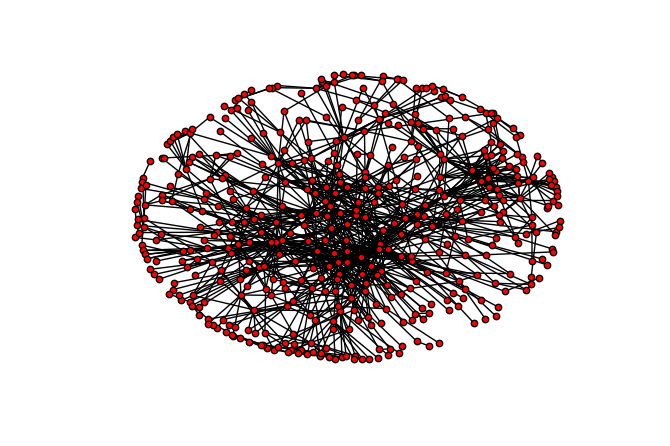

In [135]:
# Draw the 2nd sub-graph (index 1 in python)
nx.draw_spring(graphs[1], with_labels=False, node_size=21)

In [136]:
# We will be calculating three metrics on the graph: Diameter, Eccentricity and Closeness centrality.
# The diameter of a graph is the length of the longest chain you are forced to use to get from one vertex 
# to another in that graph. The diameter of this partiular graph is 6.
for i in range(0,len(graphs)):
    print nx.diameter(graphs[i]) 

1
11
2
1
1
1
2
2
1
1
1
1
1
1
1
1
1
3
1
3
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [137]:
# The maximum distance between a vertex to all other vertices is considered as the eccentricity of vertex.
# e.g. the eccentricity of sue below id 4
eccentricity = nx.eccentricity(graphs[1])
print eccentricity

{'Michigan Technological University': 9, 'ShanghaiTech University': 6, 'Tokushima University Graduate School': 9, 'Dankook University': 8, 'The University of Georgia': 9, 'Nagasaki University': 8, 'University of Southern California Los Angeles': 8, 'Utrecht University Medical Center': 8, 'Australian National University': 9, 'The University of Adelaide': 8, 'Xinxiang Medical University': 9, 'Soochow University': 7, 'Case Western Reserve University': 9, 'University Hospital': 9, 'University Medical Center Groningen': 9, 'University of Sao Paulo': 9, 'Texas Tech University Health Sciences Center': 7, 'University of Pennsylvania Perelman School of Medicine': 8, 'Shandong University': 9, 'Oxford University': 8, 'Yale University School of Medicine': 8, 'Anhui Medical University': 9, 'France Paris Descartes University': 8, 'Tongji University': 6, 'Hubei University of Medicine': 7, 'Nanjing Medical University': 6, 'Shanghai Ocean University': 8, 'Peking University': 7, 'Chongqing University': 

In [138]:
# Closeness centrality is defined as the inverse of farness, which in turn, is the sum of distances to all other nodes.
close_cent = nx.closeness_centrality(graphs[1])
print close_cent

{'Michigan Technological University': 0.17783701447067785, 'ShanghaiTech University': 0.29669631512071154, 'Tokushima University Graduate School': 0.21026564610535795, 'Dankook University': 0.2626546681664792, 'The University of Georgia': 0.22691933916423712, 'Nagasaki University': 0.25730027548209367, 'University of Southern California Los Angeles': 0.2345554997488699, 'Utrecht University Medical Center': 0.28809376927822333, 'University of Wisconsin Law School': 0.28703134603564845, 'The University of Adelaide': 0.2840632603406326, 'Xinxiang Medical University': 0.17783701447067785, 'Soochow University': 0.24617817606747497, 'Case Western Reserve University': 0.2215370018975332, 'University Hospital': 0.24386422976501307, 'University Medical Center Groningen': 0.2035745422842197, 'University of Sao Paulo': 0.23291770573566084, 'Texas Tech University Health Sciences Center': 0.2553307818480044, 'University of Pennsylvania Perelman School of Medicine': 0.22914622178606478, 'Shandong Un

In [139]:
eig_cen = nx.eigenvector_centrality(graphs[1])
print(eig_cen)

{'Michigan Technological University': 0.0002019541857596802, 'ShanghaiTech University': 0.03665356306859332, 'Tokushima University Graduate School': 0.00562625897022601, 'University of Michigan Health System': 0.009172179500784083, 'Faculty of Medicine University of Helsinki': 0.010960085135485619, 'Dankook University': 0.018844440639914237, 'The University of Georgia': 0.0043273949442843955, 'Yale School of Medicine': 0.0010303841658642714, 'Nagasaki University': 0.02355449921144154, 'University of Southern California Los Angeles': 0.007561257022001613, 'The Genitourinary Institution of Shenzhen University': 0.00022380137106484967, 'Utrecht University Medical Center': 0.055434213172579995, 'The Ohio State University Wexner Medical Center': 0.001912280853108542, 'University of Wisconsin Law School': 0.045970453343358066, 'Kitasato University School of Science': 0.0035043452058211673, 'The University of Adelaide': 0.0337147921886629, 'Xinxiang Medical University': 0.00017337999774891757

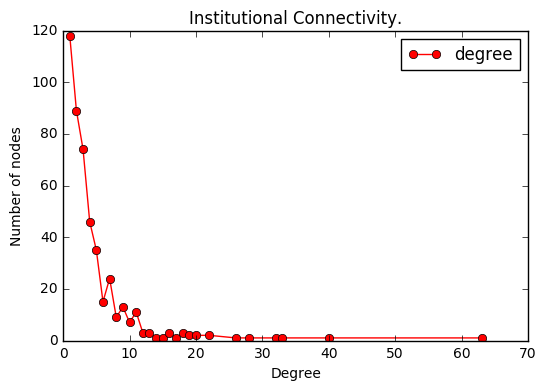

In [142]:
# We plot the number of nodes as a function of degree. 
# The node degree is the number of edges adjacent to that node.
# We see that the number of nodes decreases rapidly as the degree increases. So the nodes are fairly well dispersed.
# So there is fairly well distributed connectivity between the institutions.
degrees = graphs[1].degree()
values = sorted(set(degrees.values()))
hist = [degrees.values().count(x) for x in values]
plt.figure()
plt.plot(values,hist,'ro-') 
plt.legend(['degree']) 
plt.xlabel('Degree')
plt.ylabel('Number of nodes') 
plt.title('Institutional Connectivity.') 